In [ ]:
pip install tensorflow
pip install tdqm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import keras
from tqdm import tqdm
from random import randint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Lambda
from tensorflow.keras.losses import MeanSquaredError
import numpy as np
import json
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
# Extract data in a dataframe
reviews = []
scores = []
n = 0
with open("/drive/My Drive/6.7900 project/reviews_Amazon_Instant_Video_5.json", "r") as file:
    for line in file:
        loaded = json.loads(line)
        reviews.append(loaded["reviewText"])
        scores.append(loaded["overall"])
        n += 1

In [ ]:
# Randomize sequence
for idx in range(1, n):
    rand = randint(0, idx)
    scores[idx], scores[rand] = scores[rand], scores[idx]
    reviews[idx], reviews[rand] = reviews[rand], reviews[idx]

In [ ]:
# Create input and label
# Separate based on scores
pre_label = [[] for _ in range(5)]
pre_inp = [[] for _ in range(5)]
for idx in range(len(reviews)):
    curr_score = int(scores[idx]) - 1
    pre_inp[curr_score].append(reviews[idx])
    encode = [0.0,0.0,0.0,0.0,0.0]
    encode[curr_score] = 1.0
    pre_label[curr_score].append(encode)
# Count each score count
count = [len(pre_label[idx]) for idx in range(5)]
# Balance based on score
label = []
inp = []
for idx in range(n):
    label.append(pre_label[idx % 5][(idx // 5) % count[idx % 5]])
    inp.append(pre_inp[idx % 5][(idx // 5) % count[idx % 5]])
label = np.array(label)

In [ ]:
# Tokenize, encode, and pad
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(inp)
encoded_docs = tokenizer.texts_to_sequences(inp)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [ ]:
# Baseline Model
embedding_vector_length = 32
vocab_size = len(tokenizer.word_index)
baseline_model = Sequential()
baseline_model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
baseline_model.add(SpatialDropout1D(0.25))
baseline_model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
baseline_model.add(Dropout(0.2))
baseline_model.add(Dense(5, activation='softmax'))
baseline_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(baseline_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           1617632   
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 5)                 255       
                                                                 
Total params: 1,634,487
Trainable params: 1,634,487
Non-trainable params: 0
______________________________________________

In [ ]:
# Training
training = baseline_model.fit(padded_sequence,label,validation_split=0.2, epochs=25, batch_size=32)

Epoch 1/25
929/929 [==============================] - 245s 260ms/step - loss: 1.3550 - accuracy: 0.3747 - val_loss: 1.1265 - val_accuracy: 0.4943
Epoch 2/25
929/929 [==============================] - 243s 262ms/step - loss: 1.1346 - accuracy: 0.5013 - val_loss: 1.0096 - val_accuracy: 0.5698
Epoch 3/25
929/929 [==============================] - 240s 258ms/step - loss: 1.0383 - accuracy: 0.5528 - val_loss: 0.9567 - val_accuracy: 0.5982
Epoch 4/25
929/929 [==============================] - 241s 259ms/step - loss: 0.9761 - accuracy: 0.5867 - val_loss: 0.9242 - val_accuracy: 0.6170
Epoch 5/25
929/929 [==============================] - 240s 258ms/step - loss: 0.9184 - accuracy: 0.6184 - val_loss: 0.8905 - val_accuracy: 0.6289
Epoch 6/25
929/929 [==============================] - 233s 251ms/step - loss: 0.8859 - accuracy: 0.6274 - val_loss: 0.8091 - val_accuracy: 0.6675
Epoch 7/25
929/929 [==============================] - 233s 251ms/step - loss: 0.8452 - accuracy: 0.6469 - val_loss: 0.7946 -

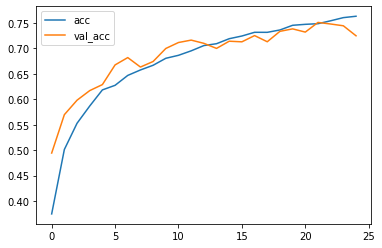

In [ ]:
# Plot accuracy
plt.plot(training.history['accuracy'], label='acc')
plt.plot(training.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

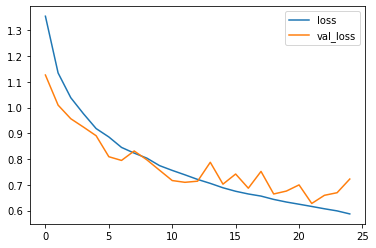

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot Loss
plt.plot(training.history['loss'], label='loss')
plt.plot(training.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plt.jpg")

In [ ]:
# Make a sentiment analysis function
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    dist = baseline_model.predict(tw, verbose = 0)
    high_prob = 0
    score = 0
    for idx in range(5):
        if dist[0][idx] > high_prob:
            high_prob = dist[0][idx]
            score = idx
    score += 1
    return score

In [ ]:
# Find accuracy with old data
correct = 0
total = 10000
N = len(reviews)
for _ in tqdm(range(total)):
    idx = randint(0, N-1)
    if predict_sentiment(reviews[idx]) == int(scores[idx]):
        correct += 1
print("accuracy =", correct / total)

100%|██████████| 10000/10000 [11:33<00:00, 14.42it/s]

accuracy = 0.7239


In [ ]:
# Extract new data
reviews = []
scores = []
with open("/drive/My Drive/6.7900 project/Digital_Music_5.json", "r") as file:
    for line in file:
        loaded = json.loads(line)
        if "reviewText" in loaded and "overall" in loaded:
            reviews.append(loaded["reviewText"])
            scores.append(loaded["overall"])

In [ ]:
# Randomize sequence
for idx in range(1, n):
    rand = randint(0, idx)
    scores[idx], scores[rand] = scores[rand], scores[idx]
    reviews[idx], reviews[rand] = reviews[rand], reviews[idx]

In [ ]:
# Find accuracy with new data
correct = 0
total = 10000
for idx in tqdm(range(total)):
    if predict_sentiment(reviews[idx]) == int(scores[idx]):
        correct += 1
print("accuracy =", correct / total)

100%|██████████| 10000/10000 [11:23<00:00, 14.63it/s]

accuracy = 0.6677


In [ ]:
cap = 1000
# Create new input and label
label = [[0,0,0,0,0] for _ in range(cap)]
inp = reviews[total : total + cap]
for idx in range(total, total + cap):
    curr_score = int(scores[idx]) - 1
    label[idx - total][curr_score] = 1
label = np.array(label)

In [ ]:
# Encode and pad
encoded_docs = tokenizer.texts_to_sequences(inp)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [ ]:
# Architecture
domain_adapt = keras.models.clone_model(baseline_model)
domain_adapt.set_weights(baseline_model.get_weights())
domain_adapt.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
domain_adapt.layers[0].trainable = False
print(domain_adapt.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           1617632   
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 5)                 255       
                                                                 
Total params: 1,634,487
Trainable params: 16,855
Non-trainable params: 1,617,632
_________________________________________

In [ ]:
# Training
training_adapt = domain_adapt.fit(padded_sequence,label,validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
25/25 [==============================] - 7s 213ms/step - loss: 0.8287 - accuracy: 0.7312 - val_loss: 0.7079 - val_accuracy: 0.7700
Epoch 2/10
25/25 [==============================] - 5s 196ms/step - loss: 0.6656 - accuracy: 0.7900 - val_loss: 0.6286 - val_accuracy: 0.7750
Epoch 3/10
25/25 [==============================] - 5s 195ms/step - loss: 0.6288 - accuracy: 0.8050 - val_loss: 0.6342 - val_accuracy: 0.7750
Epoch 4/10
25/25 [==============================] - 5s 204ms/step - loss: 0.5935 - accuracy: 0.8050 - val_loss: 0.6273 - val_accuracy: 0.7750
Epoch 5/10
25/25 [==============================] - 5s 202ms/step - loss: 0.5742 - accuracy: 0.8100 - val_loss: 0.6251 - val_accuracy: 0.7800
Epoch 6/10
25/25 [==============================] - 5s 208ms/step - loss: 0.5628 - accuracy: 0.8125 - val_loss: 0.6241 - val_accuracy: 0.7800
Epoch 7/10
25/25 [==============================] - 5s 196ms/step - loss: 0.5395 - accuracy: 0.8175 - val_loss: 0.6408 - val_accuracy: 0.7750
Epoch 

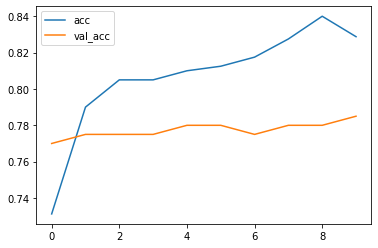

In [ ]:
# Plot Accuracy
plt.plot(training_adapt.history['accuracy'], label='acc')
plt.plot(training_adapt.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

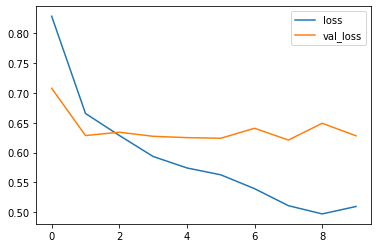

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot Loss
plt.plot(training_adapt.history['loss'], label='loss')
plt.plot(training_adapt.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plt.jpg")

In [ ]:
# Make a sentiment analysis function for domain adapt
def predict_sentiment_adapt(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    dist = domain_adapt.predict(tw, verbose = 0)
    high_prob = 0
    score = 0
    for idx in range(5):
        if dist[0][idx] > high_prob:
            high_prob = dist[0][idx]
            score = idx
    score += 1
    return score

In [ ]:
correct = 0
for idx in tqdm(range(total)):
    if predict_sentiment_adapt(reviews[idx]) == int(scores[idx]):
        correct += 1
print("accuracy =", correct / total)

100%|██████████| 10000/10000 [11:55<00:00, 13.97it/s]

accuracy = 0.8193
